Import all libraries and load in the numpy arrays

In [1]:
import pickle
import time
import os
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import time

In [2]:
X_train= pickle.load(open("Datasets/cropped256/X_train.pickle","rb"))
y_train = pickle.load(open("Datasets/cropped256/y_train.pickle","rb"))

Normalize data

In [3]:
X_train=X_train/255.0
y_train = to_categorical(y_train)

Use image data generator to augment the data

In [4]:
datagen = ImageDataGenerator(
    rotation_range=90,
    fill_mode='reflect',
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.2,1.4],
    zoom_range=0.2,
    validation_split=0.2,
    )

In [ ]:
datagen.fit(X_train)

In [5]:
import matplotlib.pyplot as plt
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=20):
    print(len(X_batch))
    print(len(y_batch))
    break

20
20


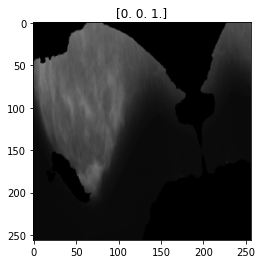

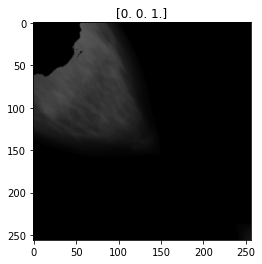

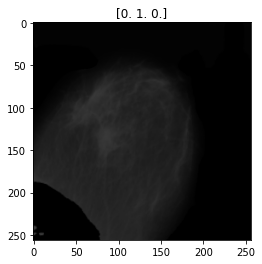

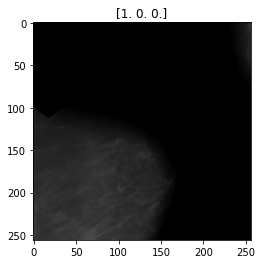

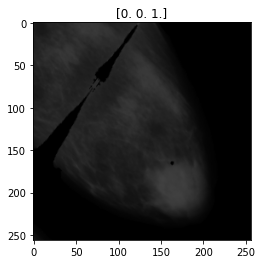

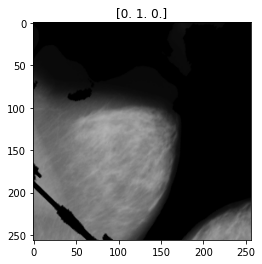

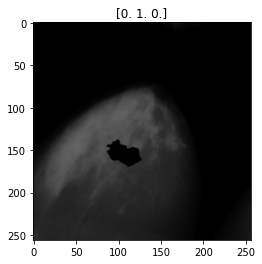

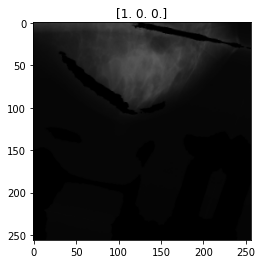

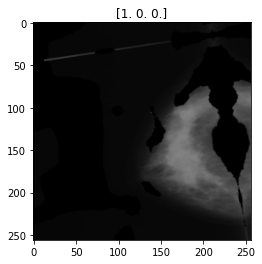

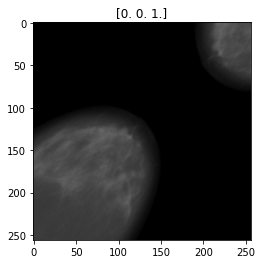

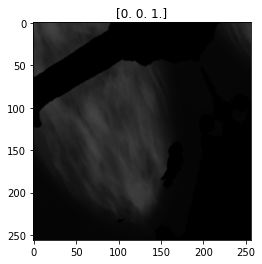

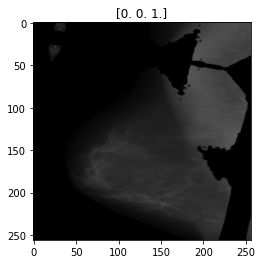

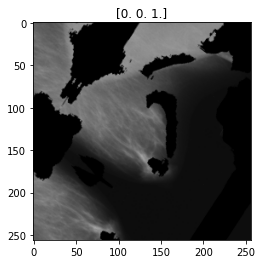

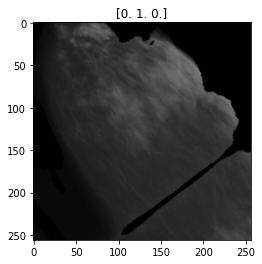

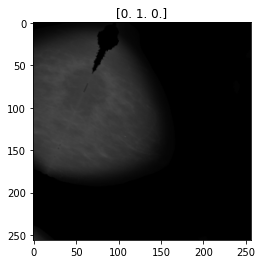

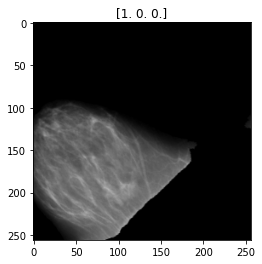

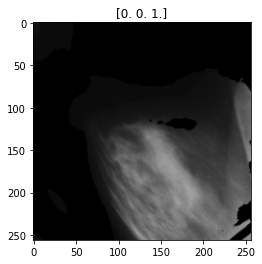

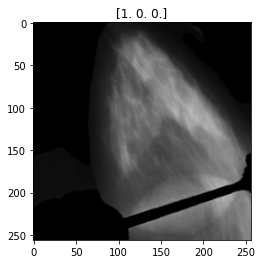

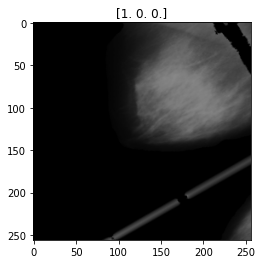

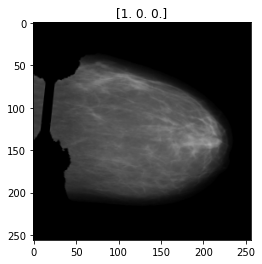

In [10]:
for image, label in zip(X_batch,y_batch):
    plt.imshow(image.astype('uint16'))
    plt.title(str(label))
    plt.show()

Define Directory Path and Augmentations

In [2]:
dirpath='C:/Users/moham/Desktop/Data/breastImages'
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect',
    )
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        dirpath+'/train',
        batch_size=12,
        target_size=(256, 256),
        class_mode='categorical',
        color_mode="rgb")
validation_generator = val_datagen.flow_from_directory(
        dirpath+'/val',
        target_size=(256, 256),
        batch_size=12,
        class_mode='categorical',
        color_mode="rgb",)

test_generator = test_datagen.flow_from_directory(
    dirpath+'/test',
    target_size=(256, 256),
    batch_size=10,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False
)

Found 3665 images belonging to 3 classes.
Found 1046 images belonging to 3 classes.
Found 527 images belonging to 3 classes.


In [3]:
print("length of train gen: "+str(len (train_generator)))
print("length of validation gen: "+str(len(validation_generator)))
print(train_generator.samples)
print(len(train_generator.class_indices))
print(int(train_generator.samples/len(train_generator.class_indices)))


print(validation_generator.samples)
print(len(validation_generator.class_indices))
print(int(validation_generator.samples/len(validation_generator.class_indices)))

print(validation_generator.class_indices)

length of train gen: 306
length of validation gen: 88
3665
3
1221
1046
3
348
{'Benign': 0, 'Cancer': 1, 'Normal': 2}


Visualize Augmented Images

In [4]:
imgs, labels= next(train_generator)

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(50,50))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('on')
    plt.tight_layout
    plt.show()

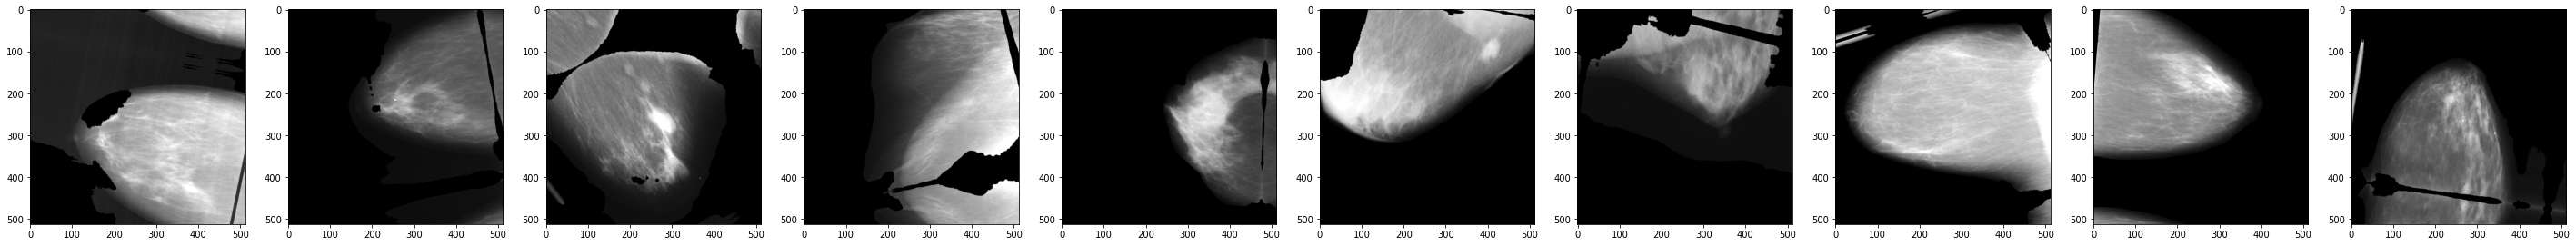

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [6]:
plotImages(imgs)
print(labels)

In [5]:
# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(256,256,3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
d1 = Dense(100, activation='relu')(flat1)
output = Dense(3, activation='softmax')(d1)
# define new model
model = Model(inputs=model.inputs, outputs=output )
# summarize
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [6]:
model.compile(loss="categorical_crossentropy",
             optimizer='adam',
             metrics=['accuracy'])

In [7]:
NAME = "VGG16-randweigths-100-3-{}".format(int(time.time()))
EarlyStop=EarlyStopping(patience=5,monitor='val_loss')
checkpoints=ModelCheckpoint(filepath=f'ModelCheckPoints/{NAME}.h5', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='DeepModels/{}'.format(NAME))
callbacks=[EarlyStop,checkpoints,tensorboard]
history=model.fit(datagen.flow(X_train, y_train, batch_size=32,
         subset='training'),
         validation_data=datagen.flow(X_train, y_train,
         batch_size=8, subset='validation'),
         steps_per_epoch=len(X_train)/4 , epochs=20,callbacks=[callbacks])
# history=model.fit(datagen.flow_from_directory(dirpath, target_size=(512,512), color_mode='rgb', classes=classes, batch_size=30,
#          class_mode='categorical', seed=seed, interpolation='nearest', subset='training',
#          steps_per_epoch=len(X_train)/10, epochs=50,callbacks=[callbacks]))
history=model.fit(train_generator,
        steps_per_epoch=len (train_generator),
        epochs=10,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
                  callbacks=[callbacks])

Epoch 1/20
105/105 [==============================] - 66s 491ms/step - loss: 1.8337 - accuracy: 0.3674 - val_loss: 1.1122 - val_accuracy: 0.3378

Epoch 00001: val_loss improved from inf to 1.11218, saving model to ModelCheckPoints\VGG16-randweigths-100-3-1633825671.h5


In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs,loss,'y', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs,acc,'y', label = "Training acc")
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title("Training and validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
# load model without classifier layers
model = InceptionV3(include_top=False, input_shape=(512,512,3),weights="imagenet")
# add new classifier layers
model.trainable=False
flat1 = Flatten()(model.layers[-1].output)
d1 = Dense(64, activation='relu')(flat1)
output = Dense(3, activation='softmax')(d1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 255, 255, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 255, 255, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 255, 255, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [9]:
model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])


In [10]:
NAME = "InceptionV3-d100-d3-{}".format(int(time.time()))
EarlyStop=EarlyStopping(patience=10,monitor='val_loss')
checkpoints=ModelCheckpoint(filepath=f'ModelCheckPoints/{NAME}.h5', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='DeepModels/{}'.format(NAME))
callbacks=[EarlyStop,checkpoints,tensorboard]
# history=model.fit(datagen.flow(X_train, y_train, batch_size=20,
#          subset='training'),
#          validation_data=datagen.flow(X_train, y_train,
#          batch_size=5, subset='validation'),
#          steps_per_epoch=len(X_train) / 40, epochs=50,callbacks=[callbacks])
history=model.fit(train_generator,
        steps_per_epoch=len (train_generator),
        epochs=50,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
                  callbacks=[callbacks])



Epoch 1/50
246/246 [==============================] - 324s 1s/step - loss: 10.8357 - accuracy: 0.5457 - val_loss: 0.9365 - val_accuracy: 0.5786

In [3]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
# load model without classifier layers
model = Xception(include_top=False, input_shape=(256,256,3),weights="imagenet")
# add new classifier layers
model.trainable=False
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1000, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [4]:
model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

In [5]:
NAME = "Xception-d1000-d3-{}".format(int(time.time()))
EarlyStop=EarlyStopping(patience=10,monitor='val_loss')
checkpoints=ModelCheckpoint(filepath=f'ModelCheckPoints/{NAME}.h5', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='DeepModels/{}'.format(NAME))
callbacks=[EarlyStop,checkpoints,tensorboard]
history=model.fit(datagen.flow(X_train, y_train, batch_size=20,
         subset='training'),
         validation_data=datagen.flow(X_train, y_train,
         batch_size=5, subset='validation'),
         steps_per_epoch=len(X_train) / 40, epochs=50,callbacks=[callbacks])
# history=model.fit(train_generator,
#         steps_per_epoch=len (train_generator),
#         epochs=50,
#         validation_data=validation_generator,
#         validation_steps=len(validation_generator),
#                   callbacks=[callbacks])

c:\users\moham\desktop\mydeeplearningproject\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/50
246/246 [==============================] - 336s 1s/step - loss: 2.5128 - accuracy: 0.5114 - val_loss: 0.8737 - val_accuracy: 0.5821

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs,loss,'y', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs,acc,'y', label = "Training acc")
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title("Training and validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
